In [1]:
!nvidia-smi

Sat May 22 05:18:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [12]:
import numpy as np
from tensorflow.keras import layers
from keras.preprocessing import image
import tensorflow as tf 
from keras.models import Model,load_model
from keras.utils import to_categorical
import os
import keras
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Lambda
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import random
from PIL import Image 
from random import shuffle
%load_ext tensorboard
import datetime


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Prepare**

In [4]:
import numpy as np
from numpy import genfromtxt
from numpy import asarray
import math
import copy
import os
from PIL import Image 
import cv2
import shutil

patch_size = 64 #input = 64x64
label_size = 128 #output = 128x128

#get RGGB bayer image
def bayer_reverse(img):
    height,width,c = img.shape;
    tmp = np.zeros([height,width]);
    for i in range( height ):
        for j in range( width ):
            if i % 2 == 0 :
                if j % 2 == 0:
                    tmp[i][j] = img[i][j][0];#R
                else:
                    tmp[i][j] = img[i][j][1];#G
            else :
                if j % 2 == 0:
                    tmp[i][j] = img[i][j][1];#G
                else:
                    tmp[i][j] = img[i][j][2];#B

    return tmp;

#split image to prepare the train set
def split(img,name,dir_path):
    height,width,c = img.shape;    
    count = 0;

    for i in range(0, height, 30):
        for j in range(0, width, 30):
            if( i + label_size < height and j + label_size < width ):                
                label = np.zeros([label_size,label_size,3])                
                tmp2  = np.zeros([label_size,label_size,3])                
                tmp2 = img[ i : i + label_size, j : j + label_size,:]
                label_img = Image.fromarray(tmp2)

                label[:,:,0] = tmp2[:,:,2]
                label[:,:,1] = tmp2[:,:,1]
                label[:,:,2] = tmp2[:,:,0]
                label_path = os.path.join(dir_path,'label/'+name.split('.')[0] +'_'+str(count)+'.png')                                                
                cv2.imwrite(label_path,label)

                
                zoom = label_img.resize((patch_size,patch_size), Image.BICUBIC)                 
                tmp3 = np.zeros([patch_size,patch_size])
                patch = np.zeros([patch_size,patch_size])

                
                zoom2 = np.array(zoom)                
                patch = bayer_reverse(zoom2)                
                                           
                patch_path = os.path.join(dir_path,'patch/'+name.split('.')[0] +'_'+str(count)+'.png')                          
                cv2.imwrite(patch_path, patch)

                count = count + 1    

def main():
    path = 'drive/My Drive/Colab Notebooks/undergraduate_project'

    if os.path.exists(os.path.join(path,'patch')):
      shutil.rmtree(os.path.join(path,'patch'))
    os.makedirs(os.path.join(path,'patch'))

    if os.path.exists(os.path.join(path,'label')):
      shutil.rmtree(os.path.join(path,'label'))
    os.makedirs(os.path.join(path,'label'))


    dataset_path = os.path.join(path,'BSD')
    entries = os.listdir(dataset_path)
    for entry in entries:
        print(entry)
        img_path = dataset_path + '/' + entry
        img = Image.open(img_path)
        img = np.array(img)   
        split(img,entry,path)



if __name__ == '__main__':
    main()


376020.png
385028.png
388016.png
249087.png
227040.png
2092.png
15088.png
15004.png
246053.png
225017.png
22093.png
20008.png
232038.png
216066.png
249061.png
247085.png
245051.png
254033.png
22090.png
16052.png
239007.png
23084.png
12074.png
22013.png
12003.png
253036.png
246016.png
236017.png
238011.png
24004.png
231015.png
239096.png
227046.png
242078.png
25098.png
24063.png
23080.png
23025.png
100098.png
104022.png
100075.png
103041.png
106020.png
108073.png
100080.png
108041.png
105019.png
105053.png
106025.png


**Training**

In [5]:
import numpy as np
from tensorflow.keras import layers
from keras.preprocessing import image
import tensorflow as tf 
from keras.models import Model,load_model
from keras.utils import to_categorical
import os
import keras
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras.layers import Lambda
from keras.optimizers import Adam
from keras import backend as K
import random
from PIL import Image 
from random import shuffle

train_image = []
train_label = []
patch_size = 64 
label_size = 128

dir_path = 'drive/My Drive/Colab Notebooks/undergraduate_project'
patch_path = os.path.join(dir_path,'patch')
entries = os.listdir(patch_path)
for entry in entries:  
  im = Image.open(patch_path+'/'+entry)
  img = image.img_to_array(im)
  # print(img.shape)
  # img = img/255.
  train_image.append(img)
train_image= np.stack(train_image)

print(train_image.shape)
  

label_path = os.path.join(dir_path,'label')
entries = os.listdir(label_path)
for entry in entries:  
  im = Image.open(label_path+'/'+entry)
  img = image.img_to_array(im)
  # img = img/255.
  train_label.append(img)
train_label = np.stack(train_label)

print(train_label.shape)



index = [i for i in range(train_image.shape[0])]
shuffle(index)
train_image = train_image[index,:,:,:];
train_label = train_label[index,:,:,:];

# np.save('drive/My Drive/Colab Notebooks/undergraduate_project/train_image.npy', train_image)
# np.save('drive/My Drive/Colab Notebooks/undergraduate_project/train_label.npy', train_label)

(4116, 64, 64, 1)
(4116, 128, 128, 3)


In [6]:
############################# Model Structure ################################################
def create_model():
  inputs = keras.Input(shape=(None,None,1))

  ##Subpixel Construction
  sub_layer_2 = Lambda(lambda x:tf.nn.space_to_depth(x,2)) 
  init = sub_layer_2(inputs=inputs)



  ##Learning Residual (DCNN)
  ####Conv 3x3x64x64 + PReLu
  x = keras.layers.Conv2D(filters = 64, #feature map number
                     kernel_size = 3, 
                     strides = 1,  # 2
                     padding = 'same', 
                     activation = 'relu',
                     input_shape = (None,None,1))(init)
  x = keras.layers.Conv2D(filters = 64, #feature map number
                     kernel_size = 3, 
                     strides = 1,  # 2
                     padding = 'same', 
                     activation = 'relu',
                     input_shape = (None,None,64))(x)
  x = keras.layers.Conv2D(filters = 64, #feature map number
                     kernel_size = 3, 
                     strides = 1,  # 2
                     padding = 'same', 
                     activation = 'relu',
                     input_shape = (None,None,64))(x)
  # x = keras.layers.BatchNormalization()(x)  
  # x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)

  ####Residual Block
  for i in range(6):
    start = x
    Conv1 = keras.layers.Conv2D(filters=64,
                        kernel_size = 1, 
                        strides = 1,  # 2
                        padding = 'same',                                             
                        input_shape = (None,None,64))(start)
    Conv1 = keras.layers.LeakyReLU()(Conv1)
    # Conv1_BN = keras.layers.BatchNormalization()(Conv1)
    # Conv1_BN = Dropout(0.5)(Conv1_BN)
    
    # PReLu = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(Conv1)
    Conv2 = keras.layers.Conv2D(filters=64,
                        kernel_size = 3, 
                        strides = 1,  # 2
                        padding = 'same',                                                
                        input_shape = (None,None,64))(Conv1)
    Conv2 = keras.layers.LeakyReLU()(Conv2)
    # Conv2_BN = keras.layers.BatchNormalization()(Conv2)
    # Conv2_BN = Dropout(0.5)(Conv2_BN)                        
    # PReLu = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(Conv2)
    Conv3 = keras.layers.Conv2D(filters=64,
                        kernel_size = 1, 
                        strides = 1,  # 2
                        padding = 'same',         
                        input_shape = (None,None,64))(Conv2)
    Conv3 = keras.layers.LeakyReLU()(Conv3)
    
    # Concatenate
    x = keras.layers.Add()([Conv3,x])
    
  ####Conv 3x3x64x64 + PReLu
  x = keras.layers.Conv2D(filters = 64,
                     kernel_size = 3, 
                     strides = 1,  # 2
                     padding = 'same',
                     activation = 'relu',
                     input_shape = (None,None,64))(x)
  x = keras.layers.Conv2D(filters = 64,
                     kernel_size = 3, 
                     strides = 1,  # 2
                     padding = 'same',
                     activation = 'relu',
                     input_shape = (None,None,64))(x)
  x = keras.layers.Conv2D(filters = 64,
                     kernel_size = 3, 
                     strides = 1,  # 2
                     padding = 'same',
                     activation = 'relu',
                     input_shape = (None,None,64))(x)
  # x = keras.layers.BatchNormalization()(x)                                                                 
  # x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)


  ####Conv 3x3x64x48
  x = keras.layers.Conv2D(filters = 48,
                     kernel_size = 3, 
                     strides = 1,  
                     padding = 'same',
                     activation = 'relu',                   
                     input_shape = (None,None,64))(x)
  x = keras.layers.Conv2D(filters = 48,
                     kernel_size = 3, 
                     strides = 1,  
                     padding = 'same',
                     activation = 'relu',                   
                     input_shape = (None,None,48))(x)
  x = keras.layers.Conv2D(filters = 48,
                     kernel_size = 3, 
                     strides = 1,  
                     padding = 'same',
                     activation = 'relu',                   
                     input_shape = (None,None,48))(x)
  x = keras.layers.BatchNormalization()(x)

  ###########Learning Residual (DCNN)############
  

  ##Recovery From Subpixel
  sub_layer = Lambda(lambda x:tf.nn.depth_to_space(x,4)) 
  Residual_Output = sub_layer(inputs=x)
  

  ##Initial Prediction
  R = Lambda(lambda x: x[:,:,:,0])(init)
  G = Lambda(lambda x: x[:,:,:,1:3])(init)
  G = Lambda(lambda x: K.mean(x, axis=3))(G)
  B = Lambda(lambda x: x[:,:,:,3])(init)
  print(init.shape)
  print(R.shape)
  print(G.shape)
  print(B.shape)
  R = Lambda(lambda x: tf.expand_dims(x, -1))(R)
  G = Lambda(lambda x: tf.expand_dims(x, -1))(G)
  B = Lambda(lambda x: tf.expand_dims(x, -1))(B)
  
  #rgb = tf.keras.backend.stack((R, G,B),axis =  3)
  print(R.shape)
  rg = keras.layers.Concatenate(axis = 3)([R , G])
  rgb = keras.layers.Concatenate(axis = 3)([rg,B])
  print(rgb.shape)
  Coarse_Output = keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(rgb) #size=4 , from W/2,H/2 ---> 2W,2H


  ## + 
  outputs = keras.layers.Add()([Residual_Output,Coarse_Output])
  #outputs = Residual_Output
 
  model = keras.Model(inputs=inputs, outputs=outputs, name="JDMSR_model")  
  return model

In [7]:
batch_size = 32
lr = 0.0001
e_num = 50
dir_path = 'drive/My Drive/Colab Notebooks/undergraduate_project'

In [8]:
model = create_model()
model.summary()

sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.0)

model.compile(optimizer=sgd, loss = 'mean_squared_error', metrics = ['accuracy'])

checkpoint = ModelCheckpoint(os.path.join(dir_path,'model.hdf5'),verbose=1, monitor='val_loss', save_best_only=True,save_weights_only=True)
rrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_lr=0.000002)
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')

history = model.fit(train_image, train_label, epochs=e_num, batch_size=batch_size,verbose=1,validation_split = 0.1,callbacks=[checkpoint, rrp, early_stopping],shuffle = True)

(None, None, None, 4)
(None, None, None)
(None, None, None)
(None, None, None)
(None, None, None, 1)
(None, None, None, 3)
Model: "JDMSR_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 4 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 2368        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928      

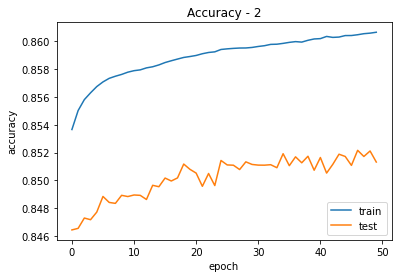

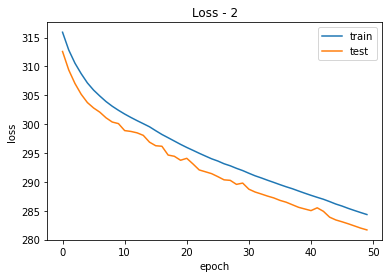

In [9]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy - 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('model_accuracy2.png')
plt.show()

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss - 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('model_loss2.png')
plt.show()

**Validation**

In [10]:
from keras.models import load_model
from keras.layers import Lambda
from keras.preprocessing import image
import keras
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from keras import backend as K
import os
import math
import shutil

width_change = 0
height_change = 0

dir_path = 'drive/My Drive/Colab Notebooks/undergraduate_project'
model = create_model()
model.load_weights(os.path.join(dir_path,'model.hdf5'))

input_path = os.path.join(dir_path, 'Set5')
output_path = os.path.join(dir_path, 'output')
output_path2 = os.path.join(dir_path, 'output2')
output_path3 = os.path.join(dir_path, 'output3')

if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs(output_path)

if os.path.exists(output_path2):
    shutil.rmtree(output_path2)
os.makedirs(output_path2)

if os.path.exists(output_path3):
    shutil.rmtree(output_path3)
os.makedirs(output_path3)

entries = os.listdir(input_path)

for entry in entries:
    # Test Image
    path = input_path+'/'+entry
    test_image = Image.open(path)
    path = output_path+'/'+entry
    test_image.save(path)
    
    test_image = test_image.resize((test_image.size[0]//2, test_image.size[1]//2), Image.BICUBIC)
    # print(test_image.size)
    test_image = np.array(test_image)
    test_image = bayer_reverse(test_image)
    test_image = test_image[:,:,np.newaxis]
    test_image = image.array_to_img(test_image)
    test_image.save(output_path3+'/'+entry)
    # print(test_image.shape)
    
    
    # print(test_image.shape)
    test_image = np.array(test_image)
    test_image = test_image[np.newaxis,:,:]
    out = model.predict(test_image)
    # print(out.shape)
    out = out[0]
    out = image.array_to_img(out)
    path = output_path2+'/'+entry
    out.save(path)

(None, None, None, 4)
(None, None, None)
(None, None, None)
(None, None, None)
(None, None, None, 1)
(None, None, None, 3)


**Performance**

In [11]:
import cv2
import numpy as np
import math
import os
from google.colab.patches import cv2_imshow
from skimage.measure import compare_ssim

def calculate_psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    max_value = 255.0
    return 20 * math.log10(max_value / math.sqrt(mse))
    

path = 'drive/My Drive/Colab Notebooks/undergraduate_project' 
input_path = os.path.join(path,'output')
output_path = os.path.join(path,'output2')
entries = os.listdir(input_path)
count = 0
total_psnr = 0.
total_ssim = 0.

for entry in entries:
  img1 = cv2.imread(os.path.join(input_path,entry))
  img2 = cv2.imread(os.path.join(output_path,entry))
  # print(img1.shape)
  # print(img2.shape)
  # img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]), interpolation=cv2.INTER_CUBIC)
  psnr = calculate_psnr(img1,img2)
  print("PSNR-{0}: {1:.10f}dB".format(entry,psnr))
  ssim = compare_ssim(img1, img2, multichannel=True)
  print("SSIM-{0}: {1:.10f}".format(entry,ssim))
  total_psnr += psnr
  total_ssim += ssim
  count += 1
print(count)
# cv2_imshow(img1)
# cv2_imshow(img2)

total_psnr = total_psnr / count
total_ssim = total_ssim / count
print("\n=====================================")
print("Average PSNR:{:.10f}".format(total_psnr))
print("Average SSIM:{:.10f}".format(total_ssim))




PSNR-head.png: 31.4950898949dB
SSIM-head.png: 0.6884166313
PSNR-bird.png: 31.5327872622dB
SSIM-bird.png: 0.8079671352
PSNR-baby.png: 32.3153118921dB
SSIM-baby.png: 0.8249889491
PSNR-butterfly.png: 29.3369299966dB
SSIM-butterfly.png: 0.7151310479


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


PSNR-woman.png: 31.8693297913dB
SSIM-woman.png: 0.8123768348
5

Average PSNR:31.3098897674
Average SSIM:0.7697761197
